## Solve a heat equation for variable diffusion D
This script includes D as an input to the network, such that the trained network solves the heat equation for a whole range of diffusion coefficients

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from neural_diff_eq.problem import Variable
from neural_diff_eq.setting import Setting
from neural_diff_eq.problem.domain import (Rectangle,
                                           Interval)
from neural_diff_eq.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from neural_diff_eq.models.fcn import SimpleFCN
from neural_diff_eq import PINNModule
from neural_diff_eq.utils import laplacian, gradient
from neural_diff_eq.utils.fdm import FDM, create_validation_data
from neural_diff_eq.utils.plot import Plotter

from neural_diff_eq.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "" # select GPUs to use

#pl.seed_everything(43) # set a global seed

We define some parameters that describe the setting:

In [2]:
w, h = 50, 50
t0, tend = 0, 1
temp_hot = 10
D_low, D_up = 5, 25  # set here the interval boundary for D

We define the independent variables of the PDE, which will later determine the inputs to the NN. Every variable has a domain and can have one or more boundary conditions.

In [3]:
x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[w, 0],
                              corner_tl=[0, h]),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})
D = Variable(name='D',
             order=0,
             domain=Interval(low_bound=D_low,
                             up_bound=D_up),
             train_conditions={},
             val_conditions={})

Now we add the wanted boundary conditions to x and t and define the norm that will be used in all training conditions. Every condition has a name string, a torch Module as a given norm (L2 in this case), a weight used during optimization, and the option to plot the training data points to tensorboard during training.

In [4]:
norm = torch.nn.MSELoss()

# Dirichlet functions should act on the given dictionarys of numpy arrays:
def x_dirichlet_fun(input):
    return np.zeros_like(input['t'])
# a DirichtletCondition generates data points at which the dirichlet_fun is evaluated
# and the Dirichlet condition is enforced. There are different strategys for sampling,
# 'random' and 'grid' are always implemented. However, the current state of 'grid' still has
# some problems in the combination of variables and is therefore not recommended yet.
x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         name='dirichlet',
                                         sampling_strategy='random',
                                         boundary_sampling_strategy='random',
                                         norm=norm,
                                         weight=1.0,
                                         dataset_size=500,
                                         data_plot_variables=('x','t')))

# the same can be done to achieve an initial condition for the time axis:
def t_dirichlet_fun(input):
    return temp_hot*np.sin(np.pi/w*input['x'][:, :1])*np.sin(np.pi/h*input['x'][:, 1:])
# to get only initial (and not end-) values, we can set boundary_sampling_strategy to sample
# only one bound of the interval
t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=500,
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x','t')))


Using the same notation, we can also define a PDE-condition to the inner of the domain.

In [5]:
# a pde function handle takes the output and the input (as a dict again) of the network. We can use
# functions like 'laplacian' from the utils part to compute common differential operators.
def pde(u, input):
    return gradient(u, input['t']) - input['D']*laplacian(u, input['x'])

# a DiffEqCondition works similar to the boundary condiitions
train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             sampling_strategy='random',
                             weight=1.0,
                             dataset_size=5000,
                             data_plot_variables=('x','t'))

For comparison during validation, we solve the problem for some D using a simple FDM scheme:

In [6]:
domain_dic = {'x': [[0, w], [0, h]]}
dx, dy = 0.5, 0.5
step_width_dict = {'x': [dx, dy]}
time_interval = [t0, tend]

D_list = [5, 10, 15, 20, 25]
# ^Here you can add many different values for D, e.g [18.8,2.5,20,....]
# The FDM-Methode will compute solutions for all D.
# For too many D this will become really memory expensive, since
# the FDM uses a forward euler!
fdm_start = timer()
domain, time, u = FDM(domain_dic, step_width_dict, time_interval,
                      D_list, t_dirichlet_fun)
fdm_end = timer()
print('Time for FDM-Solution:', fdm_end-fdm_start)
data_x, data_u = create_validation_data(domain, time, u, D_list, D_is_input=True)
# True: if D is input of the model

Time for FDM-Solution: 0.5628133900463581


Using the FDM solution, we can also define a DataCondition that measures the distance between the computed solution and the FDM solution (w.r.t. max-norm) during validation.

In [7]:
class InfNorm(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_a, input_b):
        return torch.max(torch.abs(input_a-input_b))

max_norm = InfNorm()

val_cond = DataCondition(data_x=data_x,
                         data_u=data_u,
                         name='validation',
                         norm=norm)

The variables (with their boundary conditions) as well as the conditions for the inner part of the domain are collected in a Setting:

In [8]:
setup = Setting(variables=(x, t, D),
                train_conditions={'pde': train_cond},
                val_conditions={'validation': val_cond},
                n_iterations=200,
                num_workers=0)

To solve the problem defined by setting using a PINN, we define a solver. A plotter can help us to visualize intermediate results in the tensorboard.

In [9]:
plotter = Plotter(plot_variables=setup.variables['x'],
                  points=400,
                  dic_for_other_variables={'t': 1.0, 'D': 15.0},
                  all_variables=setup.variables,
                  log_interval=1)

# the solver takes a neural network model and the created setting
# and defines which optimizer is used in training


solver = PINNModule(model=SimpleFCN(input_dim=4,
                                    depth=4,
                                    width=20),
                    problem=setup,
                    optimizer=torch.optim.Adam,
                    lr=1e-3,
                    #log_plotter=plotter
                    )

Finally, we define a lightning trainer and train the model. A lightning trainer has many options, some of them are used here:

In [10]:
trainer = pl.Trainer(gpus=None,#'-1',
                     num_sanity_val_steps=1,
                     check_val_every_n_epoch=2,
                     log_every_n_steps=1,
                     max_epochs=1,
                     checkpoint_callback=False
                     )

trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
Epoch 0: 100%|██████████| 200/200 [00:05<00:00, 33.91it/s, loss=10.5, v_num=135]


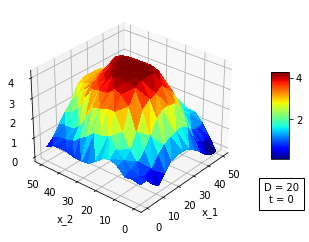

In [14]:
from neural_diff_eq.utils.plot import _plot
fig = _plot(model=solver, plot_variables=x, points=200, angle=[30, 220], 
            dic_for_other_variables={'D' : 20, 't' : 0})